<a href="https://colab.research.google.com/github/prushton2/VexScoringProgram/blob/master/RoboticsScoreProgram.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Mount Google Drive


In [181]:
from google.colab import drive
drive.mount('/content/drive', force_remount=False)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Class definitions

## Json manager class

In [0]:
import matplotlib.pyplot as plt
import csv
import json
from termcolor import colored, cprint 
import time 

null = None #I can't be bothered to remember null is None in python
true = True
false = False


class JsonManager:
  def __init__(self, path, fType): # fType should be 'score', 'comp', or 'team' depending on which json file is being opened
    self.path = path
    self.fType = fType
  def load(self):
    #opens json file and returns data
    with open(self.path, mode="r") as theFile:
      return json.load(theFile) 
      
  def save(self, data):
    #opens json file and saves data
    with open(self.path, mode="w") as theFile:
      json.dump(data, theFile)

  def addData(self, key, value, function): #Adds data to a json key, but abstracted. 
    jsonFile = self.load()#JsonManager.open()

    if(function == 'set'):
      exec("jsonFile"+str(key)+" = "+str(value))
    elif(function == 'append'):
      exec("jsonFile"+str(key)+".append("+str(value)+")")
    else:
      raise ValueError("The function parameter must be 'set' or 'append', not", function)
    self.save(jsonFile)

  

## Competition Manager

In [0]:
class Comp: #This is used as a datatype to hold the data for a competition
  def __init__(self, id, name, date, path):
    self.id = id;
    self.name = name;
    self.date = date;
    self.path = path;

  

class AllComps:
  def __init__(self, compList):
    self.compList = compList;
  def getCompFromId(self, id):
    for i in self.compList:
      if(i.id == id):
        return i

## Compiler

In [0]:
class Compiler:
  def __init__(self, comps):
    self.comps = comps;

  def setCompIDs(self, comps):
    self.comps = comps
  
  def compileComps(self): # Will compile the csv data into the jsons.
    for thisComp in self.comps:
      compFile.addData('['+str(thisComp.id)+']', {"Matches":[],"Skills":[]}, 'set')

      with open(thisComp.path, mode='r') as thisFile:
        reader = csv.DictReader(thisFile)
        line_count=0
        for row in reader:
          print("Adding match", row["Match"], "of comp", thisComp.name)
          if(int(row["Red Score"]) > int(row["Blue Score"])):
            winner = 'Red'
          elif(int(row["Blue Score"]) > int(row["Red Score"])):
            winner = 'Blue'
          else:
            winner = null
          thisMatch = [
            row["Match"],
            thisComp.id, 
            [int(row["Red Score"]), int(row["Blue Score"])],
            [row["Red Team (1)"], row["Red Team (2)"]], 
            [row["Blue Team (1)"], row["Blue Team (2)"]],
            winner
          ]

          compFile.addData('["'+str(thisComp.id)+'"]["Matches"]', thisMatch, 'append')
  
  def compileTeams(self):
    json = compFile.load()
    for i in json:
      for j in json[i]["Matches"]:
        for k in j[3]:
          try:
            teamFile.addData("['"+k+"']['Matches']", j, 'append')
            print("Added", j, "to team", k)
          except:
            teamFile.addData("['"+k+"']", {"Matches":[j],"Skills":[]}, 'set')
            print("Created team", k, "with match", j)
        for k in j[4]:
          try:
            teamFile.addData("['"+k+"']['Matches']", j, 'append')
            print("Added", j, "to team", k)
          except:
            teamFile.addData("['"+k+"']", {"Matches":[j],"Skills":[]}, 'set')
            print("Created team", k, "with match", j)

  def compileScores(self):
    scores = scoreFile.load();
    teams = teamFile.load();
    for team in teams:
      scoreFile.addData("['"+team+"']", [0], 'set')
      print("Created a record for team", team, "with 0 points")
      for match in teams[team]["Matches"]:
        scores = scoreFile.load();
        if(match[5] == 'Red'): #Create the number to add/subtract to the players score
          delta =  (int(match[2][0]) / (int(match[2][0]) + int(match[2][1])))*100
        if(match[5] == 'Blue'):
          delta =  (int(match[2][1]) / (int(match[2][0]) + int(match[2][1])))*100
        if(match[5] == null):
          delta = 0
        
        if(not(MatchHandler.hasWon(team, match))):
          delta *= -1;

        # print(team)
        z = (scores[team][len(scores[team])-1] + delta)
        scoreFile.addData('["'+team+'"]', z, 'append')
        print("Added", delta, "points to the record for team", team)

          
        


## Match Handler

In [0]:
class MatchHandler:
  @staticmethod
      
  def getColor(team, match):
    if(team == match[3][0] or team == match[3][1]):
      return "Red"
    if(team == match[4][0] or team == match[4][1]):
      return "Blue"

  def hasWon(team, match):
    if(MatchHandler.getColor(team, match) == match[5]):
      return True
    else:
      return False # set cube stack

## Team Class

In [0]:
class Team:
  def __init__(self, teamName):
    self.team = teamName;

  def hasCategory(self, category, categories):
    return category in categories or "all" == categories

  def showStats(self, categories):
    if(self.hasCategory("matches", categories)):
      teams = teamFile.load();
      for i in teams[self.team]["Matches"]:
        print(allComps.getCompFromId(i[1]).name, "on", allComps.getCompFromId(i[1]).date, "   |   ", end="")
        
        if(MatchHandler.hasWon(self.team, i)):
          color='green'
        elif(i[5] == null):
          color='grey'
        else:
          color='red'
        
        print(colored(i[0], color, attrs=['reverse', 'blink']), end='')
        print("  |  ", end='')

        if(i[5] == null):
          print(colored(i[3][0]+", "+i[3][1]+" : "+str(i[2][0])+" vs "+str(i[2][1])+" : "+i[4][0]+", "+i[4][1], 'grey'), end='')

        if(i[5] == 'Red'):
          print(colored(i[3][0]+", "+i[3][1]+" : "+str(i[2][0])+" vs ", 'red'), end='')
          print(str(i[2][1])+" : "+i[4][0]+", "+i[4][1], end='')

        if(i[5] == 'Blue'):
          print(i[3][0]+", "+i[3][1]+" : "+str(i[2][0]), end='')
          print(colored(" vs "+str(i[2][1])+" : "+i[4][0]+", "+i[4][1], 'blue'), end='')

        print("")

    if(self.hasCategory("scores", categories)):
      mplCreator.newPlot(false, s1.getScores(self.team), 'Scores')

    if(self.hasCategory("rank", categories)):
      print(self.team, "is placed", str(s1.getRank(self.team))+"/"+str(s1.getTeamCount()), end='')   

    if(self.hasCategory("score", categories)):
      if(self.hasCategory("rank", categories)):
        print(" and has", s1.getScore(self.team), "points")
      else:
        print(self.team, "has", s1.getScore(self.team), 'points')
    print('')
    
        
        
          

## Matplotlib Creators

In [0]:
class mplCreator:
  @staticmethod
  def getArrayOfLength(length):
    array = []
    for i in range(length):
      array.append(i)
    return array

  def newPlot(xArray, yArray, title):
    fig, ax = plt.subplots()
    #Create a plot instance
    
    #make it dark
    # https://matplotlib.org/3.1.1/tutorials/introductory/customizing.html
    plt.rcParams.update({
        "lines.color": "white",
        "patch.edgecolor": "white",
        "text.color": "black",
        "axes.facecolor": "black",
        "axes.edgecolor": "lightgray",
        "axes.labelcolor": "white",
        "xtick.color": "white",
        "ytick.color": "white",
        "grid.color": "lightgray",
        "figure.facecolor": "black",
        "figure.edgecolor": "black",
        "savefig.facecolor": "black",
        "savefig.edgecolor": "black"})
    #Place points on the graph
    if(xArray == False and yArray == False):
      print("We need a list, not 2 booleans")
    if(xArray == False):
      xArray = mplCreator.getArrayOfLength(len(yArray))
    if(yArray == False):
      yArray = mplCreator.getArrayOfLength(len(xArray))

    for i in range(len(yArray)):#Color in the lines fron point to point based on gain or loss
      try:
        if(yArray[i] > yArray[i+1]):
          ax.plot([xArray[i], xArray[i+1]], [yArray[i], yArray[i+1]], color='r')
        elif(yArray[i] < yArray[i+1]):
          ax.plot([xArray[i], xArray[i+1]], [yArray[i], yArray[i+1]], color='g')
        else:
          ax.plot([xArray[i], xArray[i+1]], [yArray[i], yArray[i+1]], color='b')
      except:
        print("")
    ax.scatter(xArray, yArray)
    #Set the title
    ax.set_title(title)
    #Show the plot
    fig.show()

## Score Class

In [0]:
class Score:
  def __init__(self):
    self.Ranks = []
  

  def rankTeams(self):
    IMM_scores = scoreFile.load()
    self.Ranks = []
    self.teams = []
    self.newScores = {}
    for i in IMM_scores:
      self.teams.append(i)
    print(self.teams)

    for team in IMM_scores:
      teamScore = IMM_scores[team][-1]
      rankFound = false
      print(team)

      for i in range(len(self.Ranks)):
        print(self.Ranks[i], ":", IMM_scores[self.Ranks[i]][-1], "||", end='')


      if(self.Ranks == []):
        self.Ranks = [team]
        print("--- Initialized ranks with team", team)
      else:
        i=-1
        while(not(rankFound)):
          i += 1
          # print("--- Index:", i)
          try:
            comparisonScore = IMM_scores[self.Ranks[i]][-1]
            # print("--- Comparison: Team:", self.Ranks[i], "Score:", comparisonScore)
            # print("--- This: Team:", team, "Score:", teamScore)

            if(teamScore > comparisonScore):
              # print("---", teamScore, ">", comparisonScore)
              print("--- found a spot for", team, "at place", i)
              rankFound = true
              self.Ranks.insert(i, team)
            else:
              pass
              # print("---", teamScore, "<", comparisonScore)
          except:
            rankFound = true
            self.Ranks.append(team)
            print("--- Hit list limit at", i, "appending", team, "to ranks list")
            i=-1
      pass
      self.newScores = {}
      for i in self.Ranks:
        self.newScores[i] = IMM_scores[i]
        # print(i, newScores[i])
      scoreFile.save(self.newScores)
    
  def getRank(self, givenTeam):
    scores = scoreFile.load()
    i = 0
    for team in scores:
      i += 1
      if(givenTeam == team):
        return i

  def getScore(self, givenTeam):
    scores = scoreFile.load()
    for team in scores:
      if(givenTeam == team):
        return scores[team][-1]

  def getScores(self, givenTeam):
    scores = scoreFile.load()
    for team in scores:
      if(givenTeam == team):
        return scores[team]

  def getTeamCount(self):
    i=0
    scores = scoreFile.load()
    for j in scores:
      i += 1
    return i

  def showRanks(self):
    scores = scoreFile.load()
    i = 0
    for team in scores:
      i += 1
      print(str(i)+":", team, "with a score of", scores[team][-1])

# Instantiations

In [0]:
localpath = "/content/drive/My Drive/RoboticsScoreProgram/Competitions"
compList = [
            Comp(0.0,  "Hartford",                        "10/19/19", localpath+"/VRC_10_19_19_Hartford.csv"),
            Comp(1.0,  "Quinsigamond Community College",  "11/02/19", localpath+"/VRC_11_02_19_Madison.csv"),
            Comp(2.0,  "Madison CT",                      "11/02/19", localpath+"/VRC_11_02_19_QCC.csv"),
            Comp(3.0,  "Framingham",                      "11/09/19", localpath+"/VRC_11_09_19_Framingham.csv"),
            Comp(4.0,  "Danbury",                         "11/16/19", localpath+"/VRC_11_16_19_Monroe.csv"),
            Comp(5.0,  "North Andover",                   "11/23/19", localpath+"/VRC_11_23_19_NorthAndover.csv"),
            Comp(6.0,  "Hopkinton",                       "12/07/19", localpath+"/VRC_12_07_19_Hopkinton.csv"),
            Comp(7.0,  "CTEEA Masuk",                     "12/07/19", localpath+"/VRC_12_07_19_Masuk.csv"),
            Comp(8.0,  "Quinsigamond Community College",  "12/21/19", localpath+"/VRC_12_21_19_QCC.csv"),
            Comp(9.0,  "CTEEA Bolton CT",                 "01/04/20", localpath+"/VRC_01_04_20_CTEEABolton.csv"),
            Comp(10.0, "Quinsigamond Community College",  "01/04/20", localpath+"/VRC_01_04_20_QCC.csv"),
            Comp(11.0, "CTEEA Middleton",                 "01/11/20", localpath+"/VRC_01_11_20_CTEEAMiddleton.csv"),
            Comp(12.0, "Wave at WPI",                     "01/16/20", localpath+"/VRC_01_16_20_Wave.csv"),
            Comp(13.0, "Hopkinton",                       "01/19/20", localpath+"/VRC_01_19_20_Hopkinton.csv")

]
# print(compList[-1])

allComps = AllComps(compList)
compiler = Compiler(compList)

s1 = Score()

compFile = JsonManager("/content/drive/My Drive/RoboticsScoreProgram/Json/Comps.json", 'comp')
teamFile = JsonManager("/content/drive/My Drive/RoboticsScoreProgram/Json/Teams.json", 'team')
scoreFile = JsonManager("/content/drive/My Drive/RoboticsScoreProgram/Json/Scores.json", 'score')

# Compiling
Compiles the CSV files into the JSON files

In [0]:
if(false): #This compiles the CSV files to the JSON files. Do not run unless you have made changes to the CSV files or the compiler code
  startTime = time.time()
  compFile.save({})
  teamFile.save({})
  scoreFile.save({})

  compiler.compileComps()
  compiler.compileTeams()
  compiler.compileScores()

  s1.rankTeams()

  print("Operation took", time.time()-startTime,"seconds")


# Debug

In [191]:
IMM_scores = scoreFile.load()
teams = ['977Z']
IMM_scores[teams[0]
           ][-1]

1258.2226352308212

# Show a team's scores

Framingham on 11/09/19    |   Qualifier #8  |  10102A, 2442E : 4 vs 36 : 977Z, 63857A
Framingham on 11/09/19    |   Qualifier #15  |  977Z, 4716A : 18 vs 24 : 9228B, 4716D
Framingham on 11/09/19    |   Qualifier #19  |  977Z, 9228A : 15 vs 10 : 3379A, 1898M
Framingham on 11/09/19    |   Qualifier #28  |  48425A, 2442A : 23 vs 40 : 977Z, 1898R
Framingham on 11/09/19    |   Qualifier #42  |  785Z, 64345A : 5 vs 12 : 977Z, 785E
Framingham on 11/09/19    |   Qualifier #52  |  977Z, 63857D : 30 vs 12 : 9421R, 4344X
Framingham on 11/09/19    |   Qualifier #56  |  10102X, 977Z : 12 vs 3 : 9421V, 2713B
Framingham on 11/09/19    |   Qualifier #66  |  2713A, 9421X : 27 vs 34 : 977Z, 1898A
Framingham on 11/09/19    |   R16 #3-1  |  1898A, 977Z : 39 vs 15 : 10102X, 10102A
Framingham on 11/09/19    |   QF #2-1  |  1898A, 977Z : 19 vs 3 : 63857E, 9421X
Framingham on 11/09/19    |   SF #1-1  |  1898R, 375X : 28 vs 20 : 1898A, 977Z
North Andover on 11/23/19    |   Qualifier #9  |  977Z, 4478D : 30 vs 

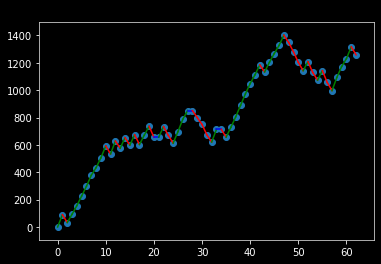

In [195]:
a977Z = Team("977Z")
a977Z.showStats('all')

# Show SNE team rankings

In [193]:
s1.showRanks();

1: 4478D with a score of 4064.5442229777714
2: 4478V with a score of 2916.692485493085
3: 41364A with a score of 2882.9617691808335
4: 375X with a score of 2757.5087130442885
5: 63857A with a score of 2618.0464801120957
6: 1898A with a score of 2385.9073312011856
7: 1898R with a score of 2255.823640548912
8: 2442B with a score of 2160.244273787166
9: 5150J with a score of 1903.8637884399495
10: 2602A with a score of 1865.6804347436407
11: 4478Z with a score of 1843.3188466801819
12: 63857D with a score of 1701.8881857844178
13: 1695B with a score of 1699.3684035881963
14: 977Z with a score of 1258.2226352308212
15: 4478R with a score of 1245.5516423034044
16: 9421X with a score of 1183.2300818660583
17: 5150G with a score of 993.9225748051196
18: 877J with a score of 975.6434226267244
19: 5150E with a score of 947.4174936541738
20: 81118P with a score of 928.5354858978802
21: 169Y with a score of 844.4076232357968
22: 4478F with a score of 792.0307549833083
23: 8079M with a score of 76

# Show matches for a comp

In [194]:
comp = compFile.load()
print(comp["12.0"])

{'Matches': [['Qualifier #1', 12.0, [5, 12], ['404Y', '1353X'], ['977Z', '9909B'], 'Blue'], ['Qualifier #2', 12.0, [30, 9], ['63857A', '242B'], ['3303D', '4180B'], 'Red'], ['Qualifier #3', 12.0, [35, 46], ['25461Z', '62G'], ['2442A', '375X'], 'Blue'], ['Qualifier #4', 12.0, [52, 9], ['4478D', '785E'], ['9909A', '11442Z'], 'Red'], ['Qualifier #5', 12.0, [19, 35], ['134C', '2142D'], ['9909C', '169Z'], 'Blue'], ['Qualifier #6', 12.0, [11, 24], ['10102A', '7121D'], ['1898A', '169E'], 'Blue'], ['Qualifier #7', 12.0, [28, 17], ['369A', '9909F'], ['7121E', '62B'], 'Red'], ['Qualifier #8', 12.0, [29, 14], ['62A', '9421X'], ['134J', '25600H'], 'Red'], ['Qualifier #9', 12.0, [12, 17], ['62K', '4478F'], ['785B', '1353P'], 'Blue'], ['Qualifier #10', 12.0, [64, 31], ['1082B', '2442F'], ['11442X', '134D'], 'Red'], ['Qualifier #11', 12.0, [27, 19], ['169Y', '63857D'], ['10102Z', '134Z'], 'Red'], ['Qualifier #12', 12.0, [34, 1], ['2442E', '2602A'], ['2602H', '1898M'], 'Red'], ['Qualifier #13', 12.0, [

# Structure
* Json Files
  * Competitions:
    * Holds every played match sorted by competition then time
  * Scores
    * Holds every team's score, and their score over time stored in a list
  * Teams
    * Stores every team, and every match they have played.

# Backlog

### Complete
* Create Json manager class
* Create competition class
* Create competition ID system
* Read and compile csvs into jsons
  * Have a json for comps and a json for teams
* Create scoring system

### In progress
* Print a teams stats nicely
* Show scores over time

### TODO

# Sprint Task List

#### Complete

#### In progress
* Iterate through team matches and print nicely
* Create class to hold team name

#### TODO

# Json format:

## Comps:
    {
      "CompName":{
        "Matches":[
          [
            "matchName",
            compId,
            [redScore, blueScore],
            [red1, red2],
            [blue1, blue2],
            "winner"
          ]
        ],
        "Skills": [
          [
            "TeamName",
            [autonScore, driverScore]
          ]
        ]
      }
    }
## Scores:

    {
      "teamNumber": [
        score1,
        score2,
        score3...
      ]
    }

## Teams:

    {
      "teamNumber": {
        "Matches: [
          "referenceToCompsJsonMatchIndex",
        ],
        "Skills": [

        ]
      }
    }


